<a href="https://colab.research.google.com/github/evanekawijaya/DSC-MCF-ITB-2022/blob/main/Uhuy_DSC_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Uhuy**

  Melvin Putra, Maxwell Thomson, Evan Eka Wijaya


# *Import Packages*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

Mounted at /content/drive


# *Read Data*

In [ ]:
#Data untuk EDA
pdrb = pd.read_excel('/content/drive/MyDrive/mcf2022/Eksternal/Q1 - PDRB per Kapita Prov (2015-2020).xlsx').set_index('Provinsi')
ppp = pd.read_excel('/content/drive/MyDrive/mcf2022/Eksternal/Q1 - PPP Prov (2015-2021).xlsx').iloc[:,:-1]
uhh = pd.read_excel('/content/drive/MyDrive/mcf2022/Eksternal/Q2 - UHH (2015-2021).xlsx').iloc[:,:-1]
pdb_lu_hk = pd.read_excel('/content/drive/MyDrive/mcf2022/Eksternal/Q3 - Simplified PDB Sektor  (2015-2021).xlsx').set_index('PDB Lapangan Usaha (Seri 2010)').iloc[:17,:-2:2]
wisata = pd.read_excel('/content/drive/MyDrive/mcf2022/Eksternal/Q3 - Jumlah Kunjungan Wisatawan.xlsx')
p1=pd.read_csv('/content/drive/MyDrive/mcf2022/Eksternal/Q4 - P1.csv',delimiter=';').iloc[:,0:8].dropna().set_index('Provinsi')
p2=pd.read_csv('/content/drive/MyDrive/mcf2022/Eksternal/Q4 - P2.csv',delimiter=';').iloc[:,0:8].dropna().set_index('Provinsi')
jpm_total=pd.read_csv('/content/drive/MyDrive/mcf2022/Eksternal/Q4 - Jumlah Penduduk Miskin (Ribu Jiwa)_V2.csv',delimiter=';').iloc[:,0:15].dropna().set_index('Provinsi')

#Data untuk pemodelan
train = pd.read_csv('/content/drive/MyDrive/mcf2022/Data_Train.csv')
test = pd.read_csv('/content/drive/MyDrive/mcf2022/Data_Test.csv')
sub = pd.read_csv('/content/drive/MyDrive/mcf2022/Sample_Submission (1).csv')

#Membuat dataframe baru yang berisi hanya provinsi dan mengganti nama kolom 'Provinsi/Kabupaten/Kota' menjadi 'Provinsi' untuk ppp dan uhh
ppp_prov = ppp[ppp['Provinsi/Kabupaten/Kota'].str.isupper()].rename(columns = {'Provinsi/Kabupaten/Kota':'Provinsi'}).set_index('Provinsi') 
uhh_prov = uhh[uhh['Provinsi/Kabupaten/Kota'].str.isupper()].rename(columns = {'Provinsi/Kabupaten/Kota':'Provinsi'}).set_index('Provinsi')

#Membuat dataframe baru yang hanya berisi data dari semester 1 untuk setiap tahun
jpm_total_tahunan = jpm_total[[col for col in jpm_total.columns if 'S1' in col]]

# EDA

## Q1

### Function

In [ ]:
pulau = {'Sumatera':0,'Jawa':1,'NT_Bali':2,'Kalimantan':3,'Sulawesi':4,'Maluku_Papua':5} #dictionary yang berisi pasangan nama pulau dengan index yang ditetapkan
pix = [0,10,16,19,24,30,34] #index pulau-pulau dalam data

#Function yang digunakan untuk menampilkan Year-over-Year (YoY) PDB Indonesia (Harga Konstan). 
def Q1_YoY_PDB():
  #Pertama-tama dilakukan slicing dataframe untuk keseluruhan Indonesia dan memanfaatkan pct_change untuk memperoleh YoY tahunan.
  pdb_indonesia_hk = pdrb.iloc[-1,6:12].to_frame(name='pdb')
  pdb_indonesia_hk['YoY'] = pdb_indonesia_hk['pdb'].pct_change()*100

  #Setelah itu memvisualisasikan bar chart dengan matplotlib.
  fig, ax1 = plt.subplots(figsize=(6, 6))
  ax1.bar(range(2015,2021), pdb_indonesia_hk['YoY'], color=np.where(pdb_indonesia_hk['YoY'] < 0, 'crimson', 'deepskyblue'))
  plt.title('PDB per Kapita (Harga Konstan) - YoY 2016-2020', fontsize = 14)
  plt.grid()
  ax1.set_ylabel('YoY (%)', fontsize = 14)

#Function yang digunakan untuk menampilkan Year-over-Year (YoY) rata-rata PDRB dari 6 Pulau di Indonesia (Harga Konstan). 
#Argumen yang diterima merupakan nama pulau (salah satu dari key dictionary pulau). 
def Q1_YoY_Mean_PDRB(nama):
  #Pertama-tama dilakukan slicing dataframe sesuai dengan indent provinsi yang sesuai dengan argumen pulau dan memanfaatkan pct_change untuk memperoleh YoY tahunan.
  i = pulau[nama]
  pdrb_hk = pdrb.drop(columns=pdrb.columns[:6]).iloc[pix[i]:pix[i+1],:]
  pdrb_hk_yoy = (pdrb_hk.pct_change(axis=1)*100).dropna(axis=1)
  pdrb_hk_yoy.loc['Rata-rata'] = pdrb_hk_yoy.mean()
  pdrb_hk_yoy_rata2 = pdrb_hk_yoy.iloc[-1,:].to_frame(name='YoY (mean)')

  #Setelah itu memvisualisasikan bar chart dengan matplotlib.
  fig, ax1 = plt.subplots(figsize=(6, 6))
  ax1.bar(range(2016,2021), pdrb_hk_yoy_rata2['YoY (mean)'], color=np.where(pdrb_hk_yoy_rata2['YoY (mean)'] < 0, 'crimson', 'deepskyblue'))
  plt.title(f'Rata-rata PDRB HK (Pulau {nama}) - YoY 2016-2020', fontsize = 14)
  plt.grid()
  ax1.set_ylabel('YoY (%)', fontsize = 14)

### PDB Indonesia

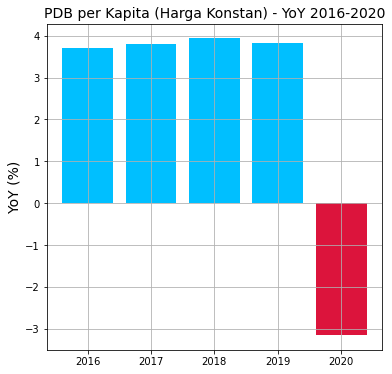

In [ ]:
Q1_YoY_PDB() #Contoh penggunaan fungsi 'Q1_YoY_PDB'

### PDRB Pulau Indonesia

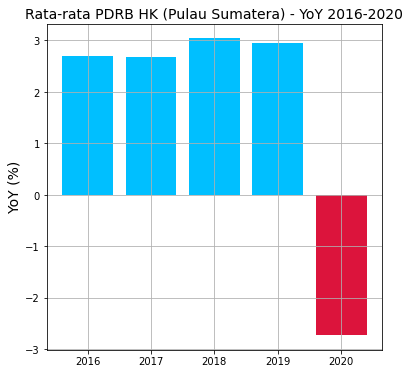

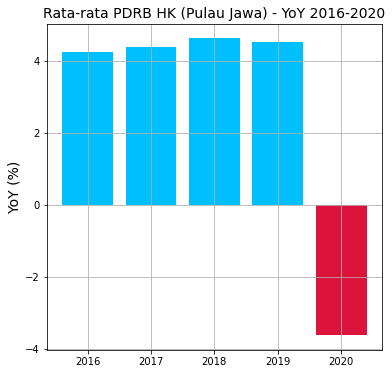

In [ ]:
#Contoh penggunaan fungsi 'Q1_YoY_Mean_PDRB' untuk data pulau Sumatera dan Jawa
Q1_YoY_Mean_PDRB('Sumatera')
Q1_YoY_Mean_PDRB('Jawa')

### PDRB Provinsi

In [ ]:
pdrb_hk = pdrb.iloc[:,6:13] #Dataframe baru yang telah dislicing untuk data PDRB harga konstan
pdrb_hk_pct_change = (pdrb_hk.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan PDRB harga konstan YoY (dalam persen) dan membuang kolom NA
pdrb_hk_pct_change = pdrb_hk_pct_change.sort_values(by='PDRB - HK (2020)',ascending=False) #Mengurutkan data berdasarkan persentase pertumbuhan tahun 2020, dari besar ke kecil

pdrb_hk_pct_change.describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan PDRB harga konstan YoY 

,PDRB - HK (2016),PDRB - HK (2017),PDRB - HK (2018),PDRB - HK (2019),PDRB - HK (2020)
count,35.000000,35.000000,35.000000,35.000000,35.000000
mean,3.618728,3.555254,4.015123,3.128965,-2.711863
std,2.003458,1.687476,3.318106,3.796042,2.303026
min,-2.501984,-1.111221,-5.608640,-17.162412,-10.217421
25%,2.927256,2.954082,3.421758,2.769071,-3.487675
50%,3.940197,3.948568,4.057270,3.777184,-2.844361
75%,4.492814,4.498173,4.928962,4.498967,-1.876631
max,8.243753,6.170683,18.833778,7.276229,3.405651


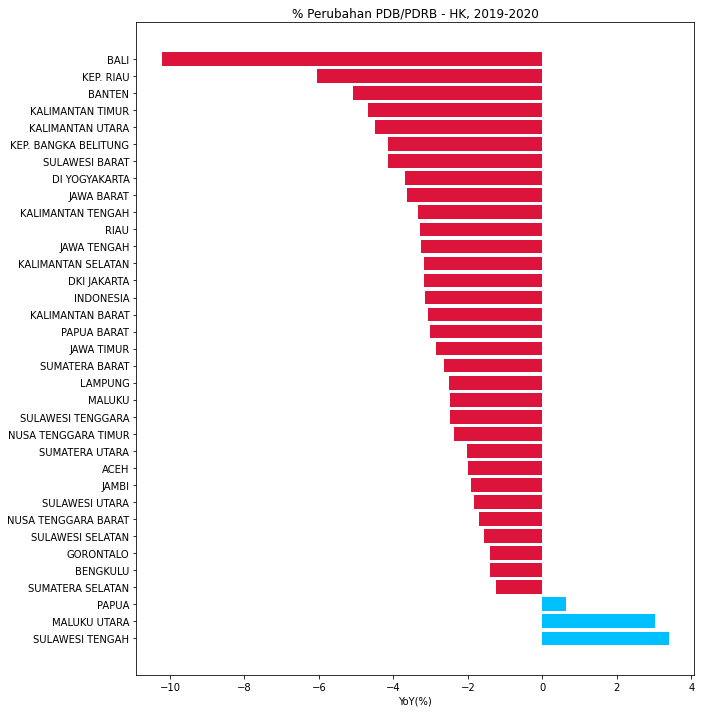

In [ ]:
#Memvisualisasikan tingkat perubahan PDRB harga konstan untuk semua provinsi pada tahun 2020 dengan bar chart
plt.figure(figsize=(10,12))
plt.barh(pdrb_hk_pct_change.index,pdrb_hk_pct_change['PDRB - HK (2020)'], color=np.where(pdrb_hk_pct_change['PDRB - HK (2020)'] < 0, 'crimson', 'deepskyblue'))
plt.title('% Perubahan PDB/PDRB - HK, 2019-2020')
plt.xlabel('YoY(%)')
plt.show()

Text(0.5, 1.0, 'Tren Pertumbuhan PDRB')

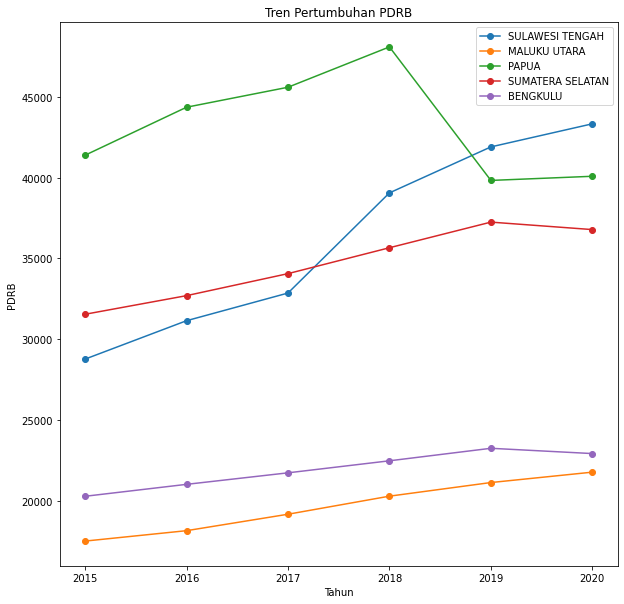

In [ ]:
#Membuat dataframe baru untuk data PDRB harga konstan namun dengan format yang berbeda (bentuk tabel ditranspose)
pdrb_konstan = pd.DataFrame()
pdrb_konstan['Tahun'] = pdrb_hk.columns
for i,j in enumerate(pdrb_hk_pct_change[:5].index):
  pdrb_konstan[j] = pdrb_hk.loc[j].values

#Memvisualisasikan tren pertumbuhan PDRB untuk 5 provinsi dengan tingkat pertumbuhan PDRB terbesar di tahun 2020 dengan line chart
plt.figure(figsize=(10,10))
for i in range(1,6):
  plt.plot('Tahun',pdrb_konstan.columns[i],data = pdrb_konstan, marker='o')
plt.legend(labels = pdrb_konstan.columns[1:],loc='best')
plt.xticks(np.arange(6),['2015','2016','2017','2018','2019','2020'])
plt.xlabel('Tahun')
plt.ylabel('PDRB')
plt.title('Tren Pertumbuhan PDRB')

### PPP (Pengeluaran per Kapita Disesuaikan)

In [ ]:
ppp_prov_change = (ppp_prov.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan Pendapatan per Kapita (PPP) YoY (dalam persen) 
ppp_prov_change.sort_values(by='PPP (2020)',ascending=False,inplace=True)  #Mengurutkan data berdasarkan persentase pertumbuhan tahun 2020, dari besar ke kecil
ppp_prov_change.describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan PPP YoY 

,PPP (2016),PPP (2017),PPP (2018),PPP (2019),PPP (2020)
count,35.000000,35.000000,35.000000,35.000000,35.000000
mean,2.566891,2.562298,3.418113,2.761395,-2.143818
std,1.138053,0.919209,0.865829,0.794010,1.443473
min,0.833434,0.867790,1.847372,1.222597,-6.282779
25%,1.607444,2.090683,2.799401,2.235006,-2.674603
50%,2.354847,2.491281,3.415155,2.616703,-1.776580
75%,3.405873,3.039629,4.051722,3.283674,-1.224408
max,4.891740,5.409070,4.972650,4.539517,-0.278605


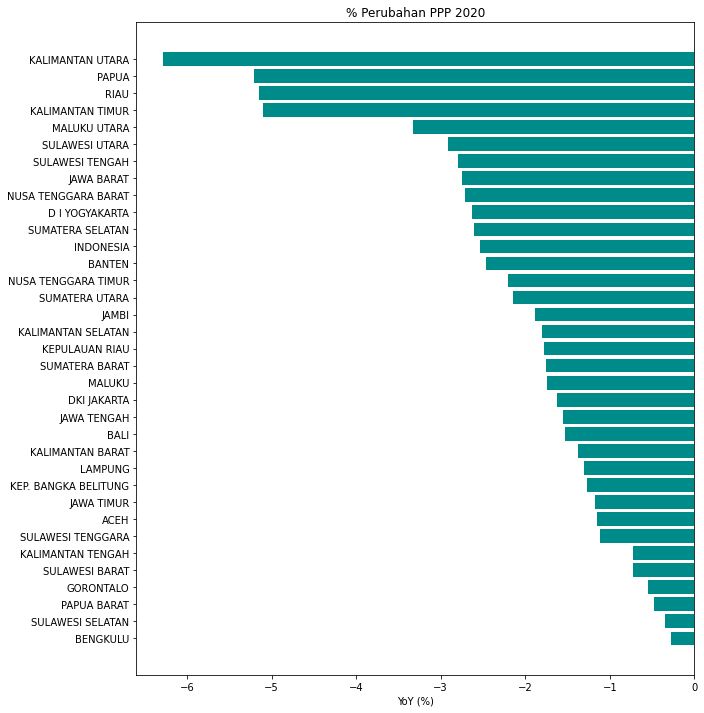

In [ ]:
#memvisualisasikan tingkat perubahan PPP untuk semua provinsi pada tahun 2020
plt.figure(figsize=(10,12))
plt.barh(ppp_prov_change.index,ppp_prov_change['PPP (2020)'], color='darkcyan')
plt.title('% Perubahan PPP 2020')
plt.xlabel('YoY (%)')
plt.show()

## Q2

### Function

In [ ]:
#Function yang digunakan untuk menampilkan Year-over-Year (YoY) rata-rata Umur Harapan Hidup (UHH) dari 6 Pulau di Indonesia. 
#Argumen yang diterima merupakan nama pulau (salah satu dari key dictionary pulau). 

def Q2_UHH(nama):
  #Pertama-tama dilakukan slicing dataframe sesuai dengan indent provinsi yang sesuai dengan argumen pulau dan memanfaatkan pct_change untuk memperoleh YoY tahunan. 
  i = pulau[nama]
  uhh = uhh_prov_change.iloc[pix[i]:pix[i+1],:]
  uhh.loc['Rata-rata'] = uhh.mean()
  uhh_rata2 = uhh.iloc[-1,:].to_frame(name='YoY (UHH)')

  #Setelah itu memvisualisasikan bar chart dengan matplotlib.
  fig, ax1 = plt.subplots(figsize=(6, 6))
  ax1.bar(range(2016,2021), uhh_rata2['YoY (UHH)'], color=np.where(uhh_rata2['YoY (UHH)'] < 0, 'crimson', 'deepskyblue'))
  plt.title(f'UHH {nama} - YoY 2016-2020', fontsize = 14)
  plt.grid()
  ax1.set_ylabel('YoY (%)', fontsize = 14)

### YoY UHH Tahunan

In [ ]:
uhh_prov_change = (uhh_prov.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan UHH YoY (dalam persen) 
uhh_prov_change.sort_values(by='Umur Harapan Hidup Saat Lahir (UHH) (2020)',ascending=True,inplace=True) #Mengurutkan data berdasarkan persentase pertumbuhan tahun 2020, dari kecil ke besar
uhh_prov_change.describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan UHH YoY

,Umur Harapan Hidup Saat Lahir (UHH) (2016),Umur Harapan Hidup Saat Lahir (UHH) (2017),Umur Harapan Hidup Saat Lahir (UHH) (2018),Umur Harapan Hidup Saat Lahir (UHH) (2019),Umur Harapan Hidup Saat Lahir (UHH) (2020)
count,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.086302,0.053021,0.300978,0.384465,0.215655
std,0.070812,0.041789,0.125646,0.174644,0.107187
min,0.014388,0.014192,0.041396,0.055172,0.068927
25%,0.042598,0.028629,0.223070,0.274342,0.168233
50%,0.058574,0.043190,0.328806,0.381064,0.198582
75%,0.102874,0.070365,0.353771,0.497492,0.235094
max,0.374169,0.225670,0.683304,0.711638,0.674190


In [ ]:
uhh_prov_change.iloc[:,-2:].head() #Melihat 5 provinsi apa yang memiliki persentase perubahan 2019-2020 yang paling rendah

,Umur Harapan Hidup Saat Lahir (UHH) (2019),Umur Harapan Hidup Saat Lahir (UHH) (2020)
Provinsi,,
KALIMANTAN UTARA,0.055172,0.068927
KALIMANTAN TENGAH,0.071798,0.071746
ACEH,0.330270,0.085874
D I YOGYAKARTA,0.133654,0.093433
JAMBI,0.239808,0.140726


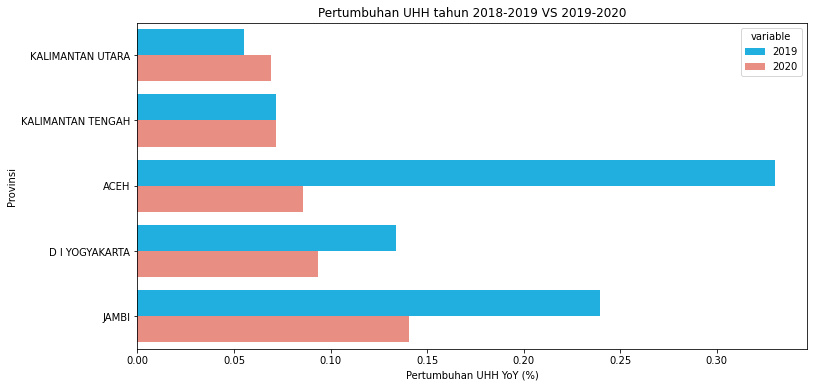

In [ ]:
#Membuat dataframe baru yang berisi persentase perubahan UHH untuk 5 provinsi dengan persentase perubahan 2019-2020 paling rendah dengan format yang berbeda
uhh_top5_tahun=['2019','2020','2019','2019','2019','2020','2019','2020','2020','2020']
uhh_top5_2=pd.melt(uhh_prov_change.head().reset_index(),id_vars=['Provinsi'],value_vars=['Umur Harapan Hidup Saat Lahir (UHH) (2019)','Umur Harapan Hidup Saat Lahir (UHH) (2020)'],ignore_index=False)
uhh_top5_2['variable']=uhh_top5_tahun

#Memvisualisasikan pertumbuhan UHH tahun 2018-2019 dan 2019-2020 untuk 5 provinsi dengan persentase perubahan paling rendah pada 2019-2020
plt.figure(figsize=(12,6))
sns.barplot(y='Provinsi',x='value',data=uhh_top5_2,hue='variable',palette=['deepskyblue','salmon'])
plt.title('Pertumbuhan UHH tahun 2018-2019 VS 2019-2020')
plt.xlabel('Pertumbuhan UHH YoY (%)')
plt.ylabel('Provinsi')
plt.savefig('pertumbuhan uhh.png')

### UHH Pulau Indonesia

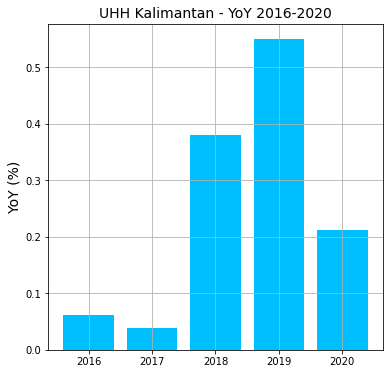

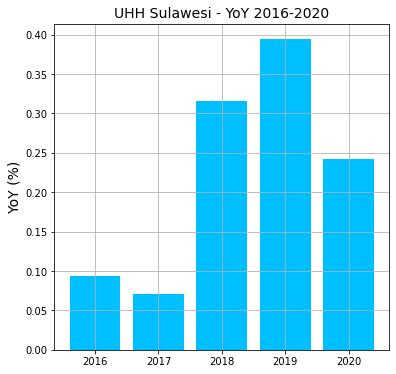

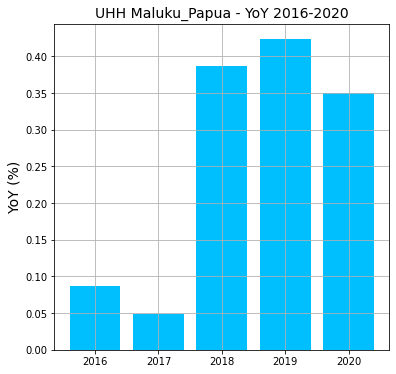

In [ ]:
#Contoh penggunaan fungsi 'Q2_UHH' untuk data pulau Kalimantan, Sulawesi, dan Maluku Papua
Q2_UHH('Kalimantan')
Q2_UHH('Sulawesi')
Q2_UHH('Maluku_Papua')

## Q3

### PDB Lapangan Usaha

In [ ]:
pdb_lu_hk_change = (pdb_lu_hk.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan PDB Lapangan Usaha (LU) YoY (dalam persen) 
pdb_lu_hk_change.sort_values(by = 'HK - Tahunan (2020)', inplace = True) #Mengurutkan data berdasarkan persentase pertumbuhan tahun 2020, dari kecil ke besar

pdb_lu_hk_change.describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan PDB LU YoY

,HK - Tahunan (2016),HK - Tahunan (2017),HK - Tahunan (2018),HK - Tahunan (2019),HK - Tahunan (2020)
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,5.264167,5.213683,5.698271,6.132508,-0.710721
std,2.199228,2.632404,1.811180,2.500719,6.655053
min,0.946910,0.656512,2.158146,1.217971,-15.047312
25%,3.839833,3.716795,4.274008,4.597863,-3.779950
50%,5.155039,4.593561,5.561469,5.787946,-1.951238
75%,7.362892,6.837044,7.020371,6.827295,2.611602
max,8.929792,9.628010,8.950091,10.574546,11.562274


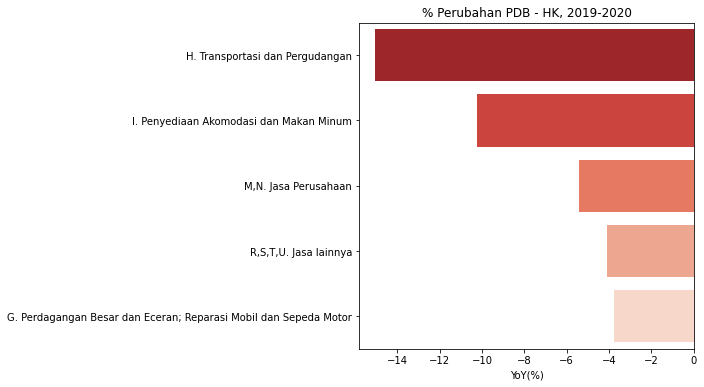

In [ ]:
#Memvisualisasikan tingkat perubahan PDB untuk 5 sektor dengan tingkat perubahan terkecil pada tahun 2020 menggunakan bar chart
plt.figure(figsize=(6,6))
sns.barplot(x=pdb_lu_hk_change['HK - Tahunan (2020)'][:5],y=pdb_lu_hk_change.index[:5],palette=("Reds_r"))
plt.title('% Perubahan PDB - HK, 2019-2020')
plt.ylabel('')
plt.xlabel('YoY(%)')
plt.show()

### Tren Wisatawan

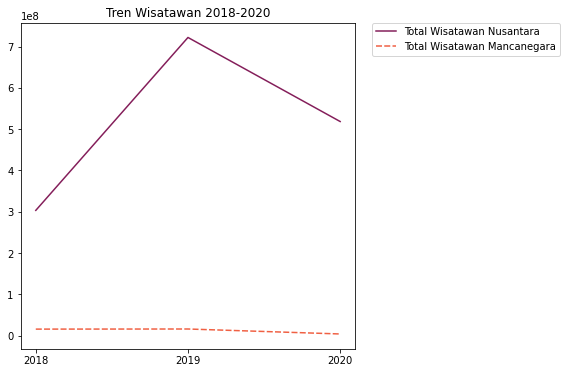

In [ ]:
#Memvisualisasikan tren wisatawan untuk tahun 2018-2020 menggunakan line chart
plt.figure(figsize=(6,6))
sns.lineplot(data=wisata.iloc[:,1:],palette=("rocket"))
plt.xticks(np.arange(3),wisata['Tahun'])
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)
plt.title('Tren Wisatawan 2018-2020')
plt.savefig('Tren wisata.png',bbox_inches='tight')

## Q4

### Function

In [ ]:
#Function yang digunakan untuk menampilkan Year-over-Year (YoY) rata-rata Jumlah Penduduk Miskin (JPM) dari 6 Pulau di Indonesia. 
#Argumen yang diterima merupakan nama pulau (salah satu dari key dictionary pulau). 
def Q4_pct(nama): 
  pulau = {'Sumatera':0,'Jawa':1,'NT_Bali':2,'Kalimantan':3,'Sulawesi':4,'Maluku_Papua':5}
  i = pulau[nama]
  pix = [0,10,16,19,24,30,34]

  #Pertama-tama dilakukan slicing dataframe sesuai dengan indent provinsi yang sesuai dengan argumen pulau dan memanfaatkan pct_change untuk memperoleh YoY tahunan. 
  jpm_pulau=jpm_total_tahunan_change.iloc[pix[i]:pix[i+1],:]
  jpm_pulau.loc['Rata rata']=jpm_pulau.mean()
  jpm_pulau_rata2=jpm_pulau.iloc[-1,:].to_frame(name='jpm_pulau_mean')

  #Setelah itu memvisualisasikan bar chart dengan matplotlib.
  fig, ax1 = plt.subplots(figsize=(6, 6))
  ax1.bar(range(2016,2022), jpm_pulau_rata2['jpm_pulau_mean'], color=np.where(jpm_pulau_rata2['jpm_pulau_mean'] < 0, 'crimson', 'deepskyblue'))
  plt.title(f'Tingkat Perubahan Jumlah Masyarakat Miskin ({nama})', fontsize = 14)
  ax1.set_ylabel('Perubahan Jumlah Masyarakat Miskin', fontsize = 14)

### YoY JPM Tahunan

In [ ]:
jpm_total_tahunan.iloc[:-1,:].describe() #Menunjukkan statistik deskriptif untuk data Jumlah Penduduk Miskin (JPM) pada provinsi-provinsi di Indonesia

,2015_S1,2016_S1,2017_S1,2018_S1,2019_S1,2020_S1,2021_S1
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,840.965294,823.687941,816.801176,763.230000,739.550882,777.177059,810.081176
std,1241.989237,1210.553668,1191.693491,1066.308208,1013.238699,1106.927498,1155.642268
min,39.690000,41.120000,49.470000,50.350000,48.780000,51.790000,52.860000
25%,207.265000,202.912500,200.502500,194.610000,191.895000,188.995000,203.505000
50%,381.655000,376.455000,375.970000,365.125000,356.885000,355.500000,369.280000
75%,844.665000,838.087500,857.725000,827.775000,806.530000,805.390000,858.982500
max,4789.120000,4703.300000,4617.010000,4332.590000,4112.250000,4419.100000,4572.730000


In [ ]:
jpm_total_tahunan_change = (100*jpm_total_tahunan.pct_change(axis=1)).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan JPM YoY (dalam persen) 
jpm_total_tahunan_change.iloc[:-1,:].describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan JPM pada provinsi-provinsi di Indonesia

,2016_S1,2017_S1,2018_S1,2019_S1,2020_S1,2021_S1
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,-1.982169,0.457056,-2.701196,-2.038912,2.527168,4.637308
std,3.189457,4.019725,4.282226,2.591097,6.988897,4.247420
min,-10.048525,-3.539150,-13.257957,-10.333071,-3.076029,0.305368
25%,-3.473332,-1.453822,-4.751004,-3.099534,-1.205916,1.590544
50%,-1.699519,-0.390755,-2.517794,-2.134342,0.251871,3.540108
75%,-0.288148,1.463499,-0.244828,-0.374444,2.572326,5.734037
max,6.073445,20.306420,6.525435,3.854653,31.544248,22.265270


### JPM Pulau Indonesia

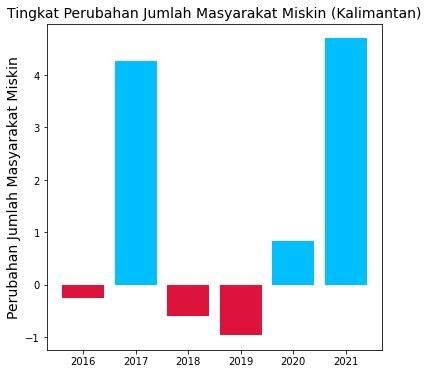

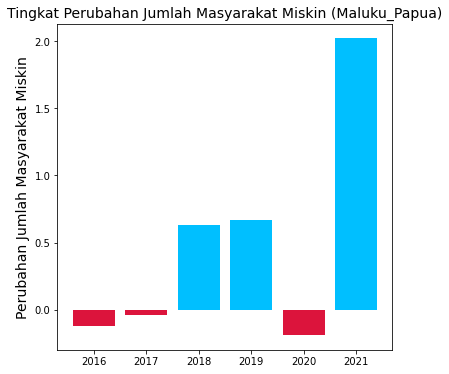

In [ ]:
#Contoh penggunaanfungsi 'Q4_pct' untuk data pulau Kalimantan dan Maluku Papua
Q4_pct('Kalimantan')
Q4_pct('Maluku_Papua')

### YoY P1 Tahunan

In [ ]:
p1_change = (p1.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan Indeks Keparahan Kemiskinan (P1) YoY (dalam persen) 
p1_change.iloc[:-1,:].describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan Indeks Keparahan Kemiskinan (P1) pada provinsi-provinsi di Indonesia

,2016_P1,2017_P1,2018_P1,2019_P1,2020_P1,2021_P1
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.243638,-3.139970,-2.643744,-7.653028,4.595691,4.472266
std,10.526260,15.639738,10.097064,9.458034,14.577817,10.836494
min,-22.727273,-32.246377,-16.847826,-31.000000,-27.586207,-13.178295
25%,-6.782744,-10.152054,-9.059561,-13.230057,-2.067443,-3.356297
50%,0.905732,-5.697772,-4.572772,-7.201844,3.211580,3.180759
75%,7.770563,0.474943,2.710213,-2.318046,10.729614,8.742409
max,15.555556,55.128205,40.816327,9.313725,60.869565,30.769231


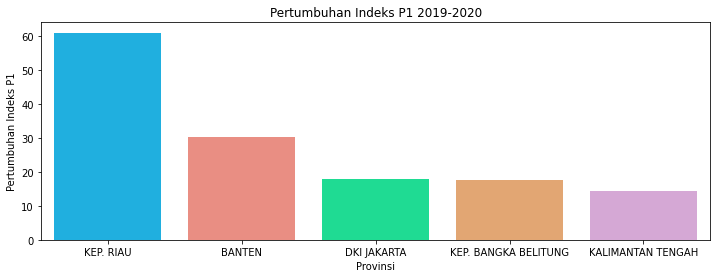

In [ ]:
#Mengurutkan data tingkat perubahan indeks P1 dari nilai terbesar ke nilai terkecil berdasarkan tingkat perubahan pada tahun 2020
p1_change.sort_values(by='2020_P1',ascending=False,inplace=True) 

#Memvisualisasikan tingkat perubahan/pertumbuhan indeks P1 2019-2020 untuk 5 provinsi dengan pertumbuhan terbesar
plt.figure(figsize=(12,4))
sns.barplot(x=p1_change['2020_P1'].head().index,y='2020_P1',data=p1_change['2020_P1'].head().to_frame(),palette=['deepskyblue','salmon','mediumspringgreen','sandybrown','plum'])
plt.title('Pertumbuhan Indeks P1 2019-2020')
plt.xlabel('Provinsi')
plt.ylabel('Pertumbuhan Indeks P1')
plt.show()

### YoY P2 Tahunan

In [ ]:
p2_change = (p2.pct_change(axis=1)*100).dropna(axis=1) #Dataframe baru yang berisi data tingkat perubahan Indeks Keparahan Kemiskinan (P2) YoY (dalam persen) 
p2_change.iloc[:-1,:].describe() #Menunjukkan statistik deskriptif untuk data tingkat perubahan Indeks Keparahan Kemiskinan (P2) pada provinsi-provinsi di Indonesia

,2016_P2,2017_P2,2018_P2,2019_P2,2020_P2,2021_P2
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1.997393,-1.956947,-2.537735,-12.591656,8.200311,7.009450
std,19.950780,29.804746,17.458130,15.598860,27.971706,21.700026
min,-35.714286,-51.111111,-25.742574,-50.000000,-45.161290,-25.000000
25%,-13.242894,-18.340909,-12.697335,-22.306723,-6.584225,-5.059746
50%,5.031056,-4.210993,-4.880952,-10.818713,4.136116,3.199710
75%,18.620148,5.661765,3.955314,-5.251025,14.756016,12.907609
max,39.393939,100.000000,75.000000,14.814815,133.333333,72.727273


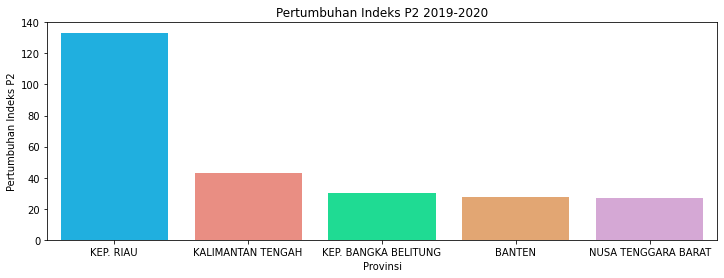

In [ ]:
#Mengurutkan data tingkat perubahan indeks P2 dari nilai terbesar ke nilai terkecil berdasarkan tingkat perubahan pada tahun 2020
p2_change.sort_values(by='2020_P2',ascending=False,inplace=True)

#Memvisualisasikan tingkat perubahan/pertumbuhan indeks P2 2019-2020 untuk 5 provinsi dengan pertumbuhan terbesar
plt.figure(figsize=(12,4))
sns.barplot(x=p2_change['2020_P2'].head().index,y='2020_P2',data=p2_change['2020_P2'].head().to_frame(),palette=['deepskyblue','salmon','mediumspringgreen','sandybrown','plum'])
plt.title('Pertumbuhan Indeks P2 2019-2020')
plt.xlabel('Provinsi')
plt.ylabel('Pertumbuhan Indeks P2')
plt.show()

# *ML Deployment*

## *Function*

### *Feature Engineering Function*

Angka minimum dan maksiumum diperoleh dari data booklet BPS: https://www.bps.go.id/website/pdf_publikasi/Booklet-IPM-Metode-Baru.pdf 

In [ ]:
UHH_max,UHH_min = 85,20
RLS_max,RLS_min = 15,0
HLS_max,HLS_min = 18,0
ln_PPP_min,ln_PPP_max = np.log(1007436/1000),np.log(26572352/1000)

def fe(df):

  for i in range(2020,2022): #Tahun 2021 & 2021
    df[f'I.RLS_{i}'] = (df[f'Rata-rata Lama Sekolah ({i})']-RLS_min)/(RLS_max-RLS_min) #Variabel Indeks Rata-rata Lama Sekolah
    df[f'I.HLS_{i}'] = (df[f'Harapan Lama Sekolah ({i})']-HLS_min)/(HLS_max-HLS_min) #Variabel Indeks Harapan Lama Sekolah
    df[f'I.PD_{i}'] = (df[f'I.RLS_{i}']+df[f'I.HLS_{i}'])*(0.5) #Variabel Indeks Pendidikan Sekolah

  df['I.PG_2021'] = (np.log(df['Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang) (2021)'])-ln_PPP_min)/(ln_PPP_max-ln_PPP_min) #Variabel Indeks Pengeluaran Sekolah
  transformed = df['Indeks Pembangunan Manusia (2021)']**(3)/(df['I.PG_2021']*df['I.PD_2021']) #Standardized IPM 
  return (transformed, np.log(df['I.PD_2020']), np.log(df['I.PD_2021']))

### *Cross Validation Function*

In [ ]:
def cv(X, y):
  lr = LinearRegression() # Model Regresi Linier
  neg_rmse = cross_val_score(lr, X, y, cv=5, scoring='neg_root_mean_squared_error') # 5-Folds CV
  print(f"5-Folds RMSE Results: {(-neg_rmse)}") 
  print(f"Average CV : {-neg_rmse.mean()}") 

## *Feature Engineering & Selection*

In [ ]:
train['transformed'],train['In.PD_2020'],train['In.PD_2021'] = fe(train) #Feature Engineering - Pembuatan Feature (untuk dataset Train dan Test)
test['transformed'],test['In.PD_2020'],test['In.PD_2021'] = fe(test)

#Set variabel predictor dan label
X = train[['transformed','In.PD_2020','In.PD_2021','Indeks Pembangunan Manusia (2020)', 'Indeks Pembangunan Manusia (2021)']]
y = train['Umur Harapan Hidup Saat Lahir (UHH) (2021)']

## *Model Validation*

In [ ]:
cv(X,y)  #Cross validation berdasarkan RMSE

5-Folds RMSE Results: [0.00677161 0.00593765 0.00640455 0.00590507 0.00668346]
Average CV : 0.0063404680818891


## *Predict*

In [ ]:
X_test = test[X.columns] #Menyiapkan feature untuk dataset Test

#Model dilatih pada data train
lr = LinearRegression()
lr.fit(X, y)

#Memperoleh hasil prediksi
y_pred = lr.predict(X_test)

#Menyiapkan template submission
submit = test[['Id']]
submit[sub.columns[1]] = y_pred
#submit.to_csv('nama.csv', index=False)